## Topic Models

**Import Packages**

In [2]:
import numpy as np
import os
import json
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
#sys.tracebacklimit = 0 # turn off the error tracebacks
import datetime
from datetime import date, timedelta
import dotenv
import boto3
import lyricsgenius
import regex as re
import pickle
import country_functions as cf
from topicmodel import TopicModel
import matplotlib.pyplot as plt

import nltk
from string import punctuation
from nltk.corpus import stopwords

from gensim.models import word2vec
import gensim.downloader

C:\ProgramData\Anaconda3\envs\country\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


#### AWS Credentials

In [3]:
# set working directory to location of .env file
env_path = '..'
original_path = os.getcwd()
os.chdir(env_path)

# Load .env and save variables
dotenv.load_dotenv()
genius_client_id=os.getenv('genius_client_id')
genius_secret=os.getenv('genius_secret')
genius_access_token=os.getenv('genius_access_token')
genius = lyricsgenius.Genius(genius_access_token)
genius.verbose = False # Turn off status messages
access_key_id=os.getenv('s3_guler_key')
access_key_secret=os.getenv('s3_guler_id')

# change back working directory to notebook location
os.chdir(original_path)

# Connect to S3 and import metadata

s3 = boto3.client(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=access_key_secret
)

bucket='country-bucket-guler'
temp_folder = '..\\data\\temp'

In [4]:
OHCO = ['decade', 'year', 'gender', 'artist_strip', 'title', 'section', 'line', 'token']

In [5]:
TOKENS_RNN = pd.read_csv(s3.get_object(Bucket=bucket, Key='data/TOKENS-RNN.csv')['Body'])

### Full corpus topic modeling

In [8]:
BOW_RNN = TOKENS_RNN.groupby(OHCO[:5] + ['token']).token.count().to_frame('n')
cf.csv_to_s3(BOW_RNN, 'BOW-RNN.csv', s3, bucket, temp_folder, 'data')

In [13]:
tm_rnn = TopicModel(BOW_RNN)
tm_rnn.n_topics = 40
tm_rnn.create_X()
tm_rnn.get_model()
tm_rnn.describe_topics()
tm_rnn.get_model_stats()

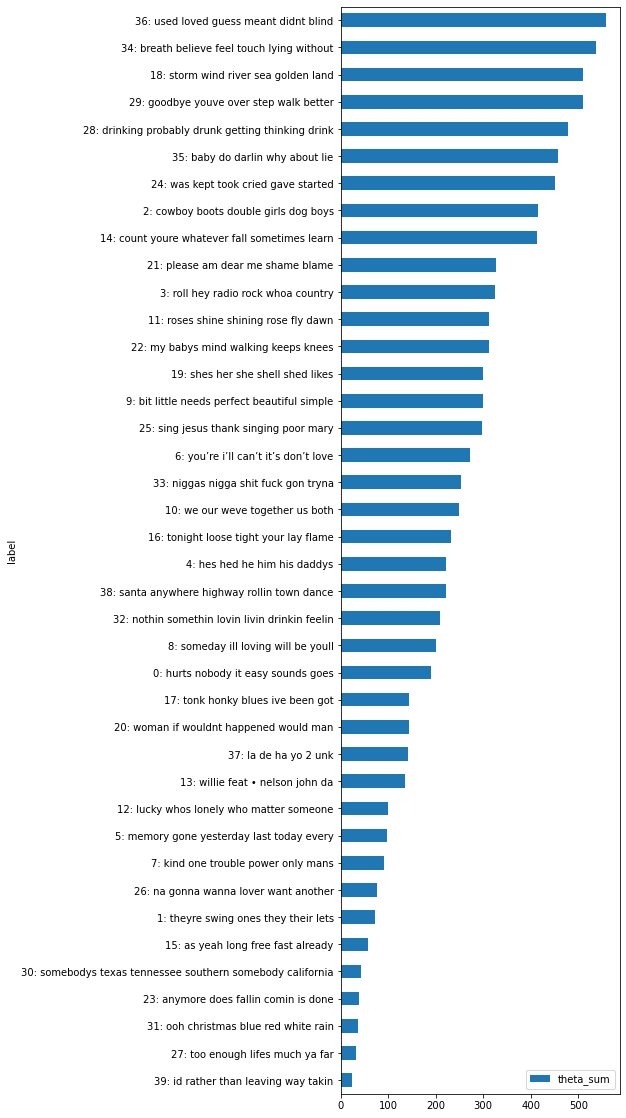

In [ ]:
tm_rnn.plot_topics()

### Exploration

In [16]:
topic_probs = pd.read_csv(s3.get_object(Bucket=bucket, Key='data/rnn-topic-probs.csv')['Body'])
topic_probs = topic_probs.set_index('term_str')

In [26]:
relative_importance = topic_probs/topic_probs.sum()

In [29]:
relative_importance['30'].sort_values(ascending=False).head(10)

term_str
tennessee     0.156336
texas         0.143414
somebody      0.086472
<l>           0.062364
california    0.059104
southern      0.054945
new           0.054098
in            0.050399
uh            0.041144
south         0.032079
Name: 30, dtype: float64

In [63]:
cf.csv_to_s3(tm_rnn.PHI.T, 'rnn-topic-probs.csv', s3, bucket, temp_folder, 'data')

In [71]:
topic_dict = {
    'lost relationship' : 36,
    'nature' : 18,
    'drinking after work' : 18,
    'relationship drama' : 35,
    'country' : 2,
    'booze cruising' : 3,
    'heartache' : 21,
    'happy religion' : 11,
    'female' : 19,
    'serious religion' : 25,
    'male' : 4,
    'honky tonking' : 17,
    'the south' : 30
}